#Реализация PathoNet на PyTorch

In [ ]:
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import cv2
from tqdm import tqdm
from skimage import measure
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
class Config:
    def __init__(self):
        self.train_img_dir = "/content/drive/MyDrive/SHIDC-B-Ki-67 V1.1/SHIDC-B-Ki-67/256x256 cropped images/train256"
        self.train_ann_dir = "/content/drive/MyDrive/SHIDC-B-Ki-67 V1.1/SHIDC-B-Ki-67/256x256 cropped images/train256"
        self.test_img_dir  = "/content/drive/MyDrive/SHIDC-B-Ki-67 V1.1/SHIDC-B-Ki-67/256x256 cropped images/test256"
        self.test_ann_dir  = "/content/drive/MyDrive/SHIDC-B-Ki-67 V1.1/SHIDC-B-Ki-67/256x256 cropped images/test256"

        self.orig_image_shape = (256,256,3)
        self.input_shape = (256,256)  # H,W
        self.num_classes = 3

        self.gaussian_size = 9
        self.gaussian_sigma = 2.0

        self.batch_size = 16
        self.epochs = 30
        self.lr = 1e-2
        self.validation_split = 0.2

        # пороги для watershed
        self.thresholds = [120, 180, 40]
        self.min_distance = 5
        self.match_radius = 10

Для изначальных точек из json сделаем гауссово распределение(аналог карты плотности по сути), значение радиуса берем из статьи

In [ ]:
def make_gaussian(size=9, sigma=2.0):
    x = np.linspace(-1,1,size)
    y = np.linspace(-1,1,size)
    xv, yv = np.meshgrid(x,y)
    d = np.sqrt(xv*xv + yv*yv)
    g = np.exp(- (d**2 / (2.0*sigma**2)))
    return g

Получаем карту распределения центров(с гауссовым распределением вокруг)

In [ ]:
class Ki67Dataset(Dataset):
    def __init__(self, img_dir, ann_dir, config: Config):
        super().__init__()
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.config  = config

        self.img_files = []
        for f in os.listdir(img_dir):
            if f.lower().endswith(".jpg") or f.lower().endswith(".png"):
                self.img_files.append(f)
        self.img_files.sort()

        self.gaussian_kernel = make_gaussian(self.config.gaussian_size,
                                             self.config.gaussian_sigma)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        with Image.open(img_path) as img_pil:
            img_pil = img_pil.convert("RGB")
            # resize к (256,256) сначала делала на больших картинках, но получилось не очень(
            img_pil = img_pil.resize((self.config.input_shape[1],
                                      self.config.input_shape[0]),
                                     Image.BICUBIC)
        img_np = np.array(img_pil).astype(np.float32)/255.0  # [H,W,3]

        h, w = self.config.input_shape
        label_map = np.zeros((h,w,self.config.num_classes), dtype=np.float32)

        base_name = os.path.splitext(img_name)[0]
        ann_path  = os.path.join(self.ann_dir, base_name + ".json")
        if os.path.exists(ann_path):
            with open(ann_path, "r") as f:
                data = json.load(f)
            orig_h, orig_w, _ = self.config.orig_image_shape

            for cdict in data:
                ox = cdict["x"]
                oy = cdict["y"]
                lbl= cdict["label_id"]  # 1->0,2->1,3->2
                label_idx = lbl -1

                sx = w/orig_w
                sy = h/orig_h
                nx = int(round(ox*sx))
                ny = int(round(oy*sy))

                gsize = self.config.gaussian_size
                half = gsize//2
                x1 = nx - half
                x2 = nx + half+1
                y1 = ny - half
                y2 = ny + half+1

                kx1, ky1 = 0,0
                if x1<0:
                    kx1= -x1
                    x1= 0
                if y1<0:
                    ky1= -y1
                    y1= 0
                kx2, ky2 = gsize,gsize
                if x2>w:
                    kx2 = gsize-(x2-w)
                    x2  = w
                if y2>h:
                    ky2 = gsize-(y2-h)
                    y2  = h

                if 0 <= label_idx < self.config.num_classes:
                    label_map[y1:y2, x1:x2, label_idx] += self.gaussian_kernel[ky1:ky2, kx1:kx2]

        label_map = np.clip(label_map,0,1)

        img_t   = torch.from_numpy(img_np).permute(2,0,1)   # [3,H,W]
        label_t = torch.from_numpy(label_map).permute(2,0,1)# [3,H,W]
        return img_t, label_t

Архитектура PathoNet + Inception modules

In [ ]:
class RDIM_Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.rep_input = (out_channels == 2*in_channels)

        self.convA1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.bnA1   = nn.BatchNorm2d(out_channels)
        self.convA2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnA2   = nn.BatchNorm2d(out_channels)

        self.convB1 = nn.Conv2d(in_channels, out_channels, 3, dilation=4, padding=4, bias=False)
        self.bnB1   = nn.BatchNorm2d(out_channels)
        self.convB2 = nn.Conv2d(out_channels, out_channels, 3, dilation=4, padding=4, bias=False)
        self.bnB2   = nn.BatchNorm2d(out_channels)

        self.leaky = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        a = self.leaky(self.bnA1(self.convA1(x)))
        a = self.leaky(self.bnA2(self.convA2(a)))

        b = self.leaky(self.bnB1(self.convB1(x)))
        b = self.leaky(self.bnB2(self.convB2(b)))

        out = a+b
        if self.rep_input:
            out += torch.cat([x,x], dim=1)
        else:
            out += x
        out = self.leaky(out)
        return out

class RDIM_Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn_in   = nn.BatchNorm2d(out_channels)

        self.convA1 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnA1   = nn.BatchNorm2d(out_channels)
        self.convA2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnA2   = nn.BatchNorm2d(out_channels)

        self.convB1 = nn.Conv2d(out_channels, out_channels, 3, dilation=4, padding=4, bias=False)
        self.bnB1   = nn.BatchNorm2d(out_channels)
        self.convB2 = nn.Conv2d(out_channels, out_channels, 3, dilation=4, padding=4, bias=False)
        self.bnB2   = nn.BatchNorm2d(out_channels)

        self.leaky = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        x_in = self.leaky(self.bn_in(self.conv_in(x)))

        a = self.leaky(self.bnA1(self.convA1(x_in)))
        a = self.leaky(self.bnA2(self.convA2(a)))

        b = self.leaky(self.bnB1(self.convB1(x_in)))
        b = self.leaky(self.bnB2(self.convB2(b)))

        out = a + b + x_in
        out = self.leaky(out)
        return out

class PathoNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.conv1_1 = nn.Conv2d(3,16,3,padding=1,bias=False)
        self.bn1_1   = nn.BatchNorm2d(16)
        self.conv1_2 = nn.Conv2d(16,16,3,padding=1,bias=False)
        self.bn1_2   = nn.BatchNorm2d(16)
        self.leaky   = nn.LeakyReLU(0.1, inplace=True)

        self.pool = nn.MaxPool2d(2,2)

        self.rdim_e2 = RDIM_Encoder(16,32)
        self.rdim_e3 = RDIM_Encoder(32,64)
        self.rdim_e4 = RDIM_Encoder(64,128)
        self.rdim_e5 = RDIM_Encoder(128,256)

        self.drop = nn.Dropout(0.1)
        self.up   = nn.Upsample(scale_factor=2, mode='nearest')

        self.rdim_d6 = RDIM_Decoder(256,128)
        self.rdim_d7 = RDIM_Decoder(128+128,64)
        self.rdim_d8 = RDIM_Decoder(64+64,32)
        self.rdim_d9 = RDIM_Decoder(32+32,16)

        self.conv_final_1 = nn.Conv2d(16+16,16,3,padding=1,bias=False)
        self.bn_final_1   = nn.BatchNorm2d(16)
        self.conv_final_2 = nn.Conv2d(16,16,3,padding=1,bias=False)
        self.bn_final_2   = nn.BatchNorm2d(16)
        self.conv_final_3 = nn.Conv2d(16,8,3,padding=1,bias=False)
        self.bn_final_3   = nn.BatchNorm2d(8)

        self.conv_last = nn.Conv2d(8,num_classes,1,bias=True)

    def forward(self, x):
        x1 = self.leaky(self.bn1_1(self.conv1_1(x)))
        x1 = self.leaky(self.bn1_2(self.conv1_2(x1)))
        p1 = self.pool(x1)

        x2 = self.rdim_e2(p1)
        p2 = self.pool(x2)
        x3 = self.rdim_e3(p2)
        p3 = self.pool(x3)
        x4 = self.rdim_e4(p3)
        p4 = self.pool(x4)
        drop4 = self.drop(p4)
        x5 = self.rdim_e5(drop4)
        drop5 = self.drop(x5)

        up6 = self.up(drop5)
        d6  = self.rdim_d6(up6)
        merge6 = torch.cat([x4,d6], dim=1)

        up7 = self.up(merge6)
        d7  = self.rdim_d7(up7)
        merge7 = torch.cat([x3,d7], dim=1)

        up8 = self.up(merge7)
        d8  = self.rdim_d8(up8)
        merge8 = torch.cat([x2,d8], dim=1)

        up9 = self.up(merge8)
        d9  = self.rdim_d9(up9)
        merge9 = torch.cat([x1,d9], dim=1)

        f1 = self.leaky(self.bn_final_1(self.conv_final_1(merge9)))
        f2 = self.leaky(self.bn_final_2(self.conv_final_2(f1)))
        f3 = self.leaky(self.bn_final_3(self.conv_final_3(f2)))

        out = self.conv_last(f3)
        return out

In [ ]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.MSELoss()
    running_loss = 0.

    pbar = tqdm(loader, desc="Train", leave=False)
    for img_t, label_t in pbar:
        img_t = img_t.to(device)
        label_t = label_t.to(device)

        optimizer.zero_grad()
        pred = model(img_t)
        loss = criterion(pred, label_t)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*img_t.size(0)
        pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    epoch_loss = running_loss/len(loader.dataset)
    return epoch_loss

def validate_one_epoch(model, loader, device):
    model.eval()
    criterion = nn.MSELoss()
    val_loss = 0.
    with torch.no_grad():
        pbar = tqdm(loader, desc="Val", leave=False)
        for img_t, label_t in pbar:
            img_t = img_t.to(device)
            label_t = label_t.to(device)
            pred = model(img_t)
            loss = criterion(pred, label_t)
            val_loss += loss.item()*img_t.size(0)
            pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    val_loss /= len(loader.dataset)
    return val_loss

Watershed к выходу модели, ищем координаты центров клеток

In [ ]:
def postprocess_density_map(density_map, thresholds, min_distance=5):
    all_points = []
    num_classes = density_map.shape[2]

    for c_idx in range(num_classes):
        ch = density_map[:,:,c_idx]
        mask = (ch >= thresholds[c_idx]).astype(np.uint8) * 255
        dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
        coords = peak_local_max(dist, min_distance=min_distance, labels=mask)
        localMax = np.zeros(dist.shape, dtype=bool)
        for (rr, cc) in coords:
            localMax[rr, cc] = True
        markers = ndimage.label(localMax, structure=np.ones((3,3)))[0]
        dist_neg = -dist
        labels_ws = watershed(dist_neg, markers, mask=(mask > 0))
        # тут получаем центры всех зон после водораздела
        for lab in np.unique(labels_ws):
            if lab == 0:
                continue
            reg = (labels_ws == lab)
            dist_reg = dist * reg
            yx = np.unravel_index(np.argmax(dist_reg), dist_reg.shape)
            cy, cx = yx
            all_points.append([cx, cy, c_idx])

    return np.array(all_points)


Считаем метрики(Precision, Recall, F1) для каждого класса отдельно и общие

In [ ]:
def detection_metrics(pred_points, gt_points, radius=10):
    from collections import defaultdict
    pred_by_class = defaultdict(list)
    gt_by_class   = defaultdict(list)

    for px,py,c in pred_points:
        pred_by_class[int(c)].append((px,py))
    for gx,gy,c in gt_points:
        gt_by_class[int(c)].append((gx,gy))

    results = {}
    for cls in range(3):
        preds = pred_by_class[cls]
        gts   = gt_by_class[cls]
        if len(preds)==0 and len(gts)==0:
            results[cls] = (1.0,1.0,1.0, 0,0,0)
            continue
        pred_used = set()
        gt_used   = set()
        r2 = radius*radius

        for i,(px,py) in enumerate(preds):
            best_j = -1
            best_d2= r2
            for j,(gx,gy) in enumerate(gts):
                if j in gt_used: continue
                dx= px-gx
                dy= py-gy
                d2= dx*dx + dy*dy
                if d2<=best_d2:
                    best_d2= d2
                    best_j= j
            if best_j>=0:
                pred_used.add(i)
                gt_used.add(best_j)

        TP= len(gt_used)
        FP= len(preds)-TP
        FN= len(gts)-TP
        prec= TP/(TP+FP+1e-8)
        rec = TP/(TP+FN+1e-8)
        f1 = 2*prec*rec/(prec+rec+1e-8)
        results[cls] = (prec, rec, f1, TP, FP, FN)

    tp_sum= sum(results[c][3] for c in results)
    fp_sum= sum(results[c][4] for c in results)
    fn_sum= sum(results[c][5] for c in results)
    mic_prec= tp_sum/(tp_sum+fp_sum+1e-8)
    mic_rec = tp_sum/(tp_sum+fn_sum+1e-8)
    mic_f1  = 2*mic_prec*mic_rec/(mic_prec+mic_rec+1e-8)
    return results, (mic_prec, mic_rec, mic_f1)

Обучение модели(по графику видно, что немного есть переобучение, но я сохраняю модель с лучшим скором на валидации, поэтому все ок)

c:\Users\andre\Downloads\Work\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train folder total images=1656, training=1325, val=331
Epoch 1/10


  train_loss=0.0224, val_loss=0.0201
  (Saved best model)
Epoch 2/10


  train_loss=0.0151, val_loss=0.0149
  (Saved best model)
Epoch 3/10


  train_loss=0.0138, val_loss=0.0136
  (Saved best model)
Epoch 4/10


  train_loss=0.0133, val_loss=0.0136
  (Saved best model)
Epoch 5/10


  train_loss=0.0127, val_loss=0.0129
  (Saved best model)
Epoch 6/10


  train_loss=0.0125, val_loss=0.0117
  (Saved best model)
Epoch 7/10


  train_loss=0.0122, val_loss=0.0126
Epoch 8/10


  train_loss=0.0120, val_loss=0.0117
  (Saved best model)
Epoch 9/10


  train_loss=0.0118, val_loss=0.0111
  (Saved best model)
Epoch 10/10


  train_loss=0.0115, val_loss=0.0136


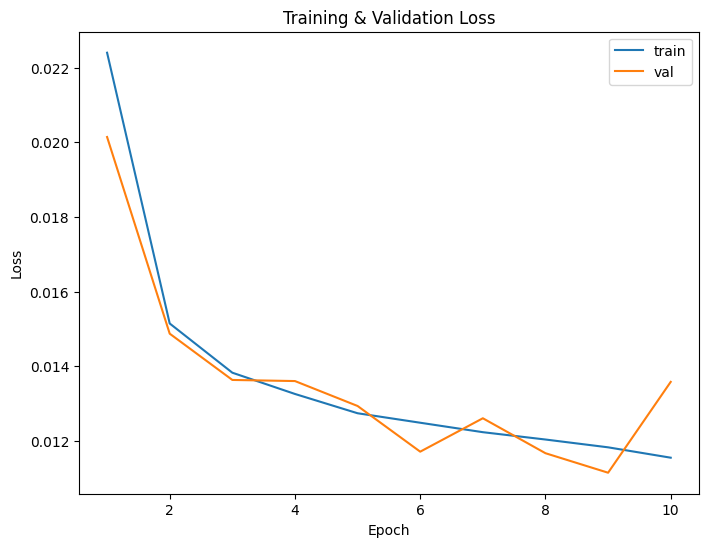

In [ ]:
model = PathoNet(num_classes=cfg.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min",
                                                       factor=0.5,    # LR падает в 2 раза
                                                       patience=2,    # 3 эпохи без улучшения
                                                       verbose=True)

best_val = float("inf")
train_losses = []
val_losses = []

for epoch in range(cfg.epochs):
    print(f"Epoch {epoch+1}/{cfg.epochs}")
    tr_loss = train_one_epoch(model, train_loader, optimizer, device)
    vl_loss = validate_one_epoch(model, val_loader, device)
    train_losses.append(tr_loss)
    val_losses.append(vl_loss)
    print(f"  train_loss={tr_loss:.4f}, val_loss={vl_loss:.4f}")

    scheduler.step(vl_loss)

    if vl_loss < best_val:
        best_val = vl_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("  (Saved best model)")

plt.figure(figsize=(8,6))
plt.plot(range(1, cfg.epochs+1), train_losses, label="train")
plt.plot(range(1, cfg.epochs+1), val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


Посмотрим как выглядит результат работы на примерах из теста

In [ ]:
def visualize_single_image(
    model,
    test_dataset,
    device,
    cfg,
    index=0
):

    img_t, _ = test_dataset[index]
    img_np  = img_t.numpy().transpose(1,2,0)
    base_name = test_dataset.img_files[index]

    json_path = os.path.join(cfg.test_ann_dir, os.path.splitext(base_name)[0] + ".json")

    gt_points_list = []
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            data = json.load(f)
        for d in data:
            class_idx = d["label_id"] - 1
            x_, y_ = d["x"], d["y"]
            if 0<=class_idx<cfg.num_classes:
                gt_points_list.append([x_, y_, class_idx])
    gt_points = np.array(gt_points_list)

    model.eval()
    with torch.no_grad():
        pred_t = model(img_t.unsqueeze(0).to(device))
    pred_np = pred_t[0].cpu().numpy().transpose(1,2,0)
    pred_np = np.clip(pred_np,0,1)

    pred_points = postprocess_density_map(pred_np, cfg.thresholds, cfg.min_distance)

    plt.figure(figsize=(12,6))
    # слева: предикт
    plt.subplot(1,2,1)
    plt.imshow(img_np, interpolation='nearest')
    plt.title("Predicted Points")
    plt.axis('off')
    color_map_pred = {0:'red', 1:'yellow', 2:'cyan'}
    for (px,py,cls_idx) in pred_points:
        c = color_map_pred.get(cls_idx,'white')
        plt.scatter(px,py,s=15,c=c,marker='o',edgecolors='black')

    # справа: GT
    plt.subplot(1,2,2)
    plt.imshow(img_np, interpolation='nearest')
    plt.title("GT Points")
    plt.axis('off')
    color_map_gt = {0:'magenta',1:'yellow',2:'cyan'}
    for (gx,gy,cls_idx) in gt_points:
        cc = color_map_gt.get(cls_idx,'white')
        plt.scatter(gx,gy,s=15,c=cc,marker='o',edgecolors='black')

    plt.show()

# тестовые данные
test_ds = Ki67Dataset(cfg.test_img_dir, cfg.test_ann_dir, cfg)

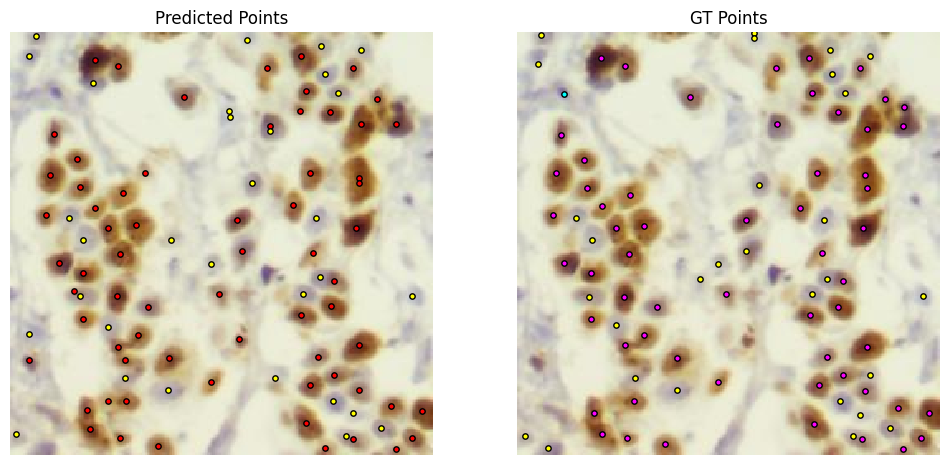

In [ ]:
visualize_single_image(model, test_ds, device, cfg, index=456)

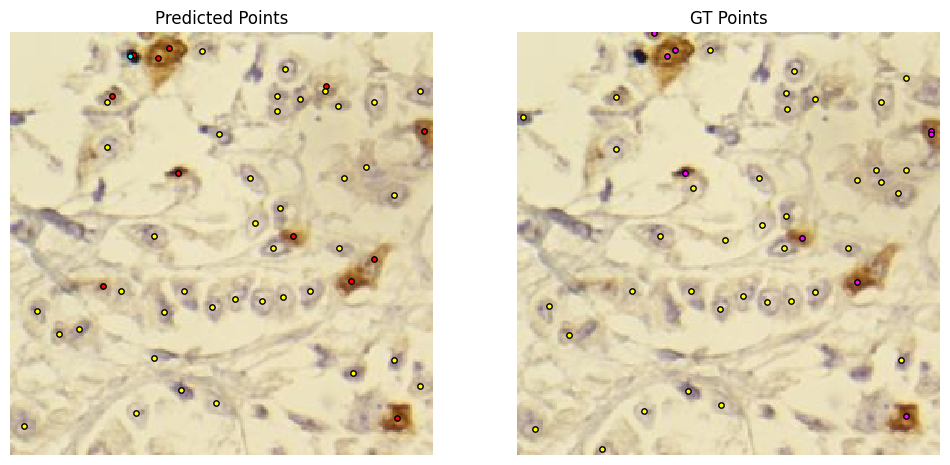

In [ ]:
visualize_single_image(model, test_ds, device, cfg, index=234)

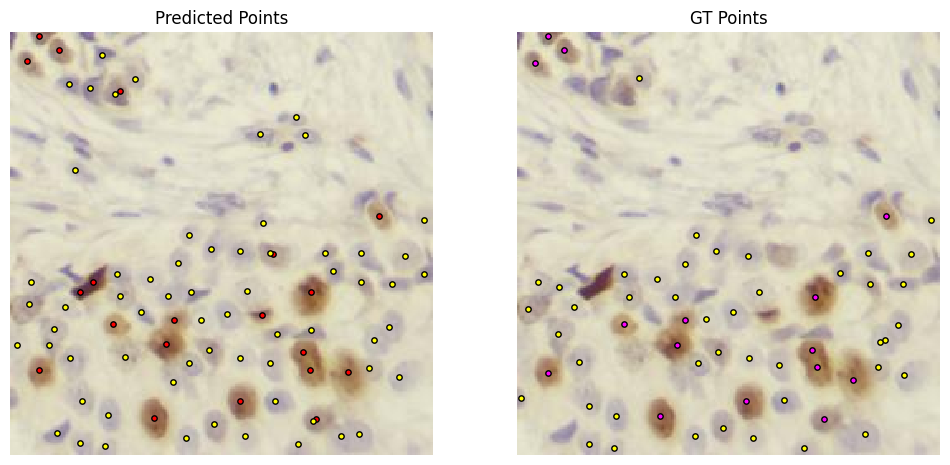

In [ ]:
visualize_single_image(model, test_ds, device, cfg, index=123)

А теперь посчитаем метрики

In [ ]:
if os.path.isdir(cfg.test_img_dir) and os.path.isdir(cfg.test_ann_dir):
    # выбираем лучшую модель
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.eval()

    test_ds = Ki67Dataset(cfg.test_img_dir, cfg.test_ann_dir, cfg)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

    from collections import defaultdict
    per_class_sum = {0:[0,0,0], 1:[0,0,0], 2:[0,0,0]}  # [TP,FP,FN]

    for i, (img_t, label_t) in enumerate(tqdm(test_loader, desc="Test")):
        img_name = test_ds.img_files[i]
        base_name = os.path.splitext(img_name)[0]
        ann_path = os.path.join(cfg.test_ann_dir, base_name + ".json")

        # собираем GT точки из JSON
        gt_points_list = []
        if os.path.exists(ann_path):
            with open(ann_path, "r") as f:
                data = json.load(f)
            for d in data:
                cls_ = d["label_id"] - 1
                x_ = d["x"]
                y_ = d["y"]

                gt_points_list.append([x_, y_, cls_])
        else:
            continue
        gt_points = np.array(gt_points_list)

        with torch.no_grad():
            pred = model(img_t.to(device))
        pred_np = pred[0].cpu().numpy().transpose(1,2,0)
        pred_np = np.clip(pred_np,0,1)

        pred_points = postprocess_density_map(pred_np, cfg.thresholds, cfg.min_distance)

        results, _ = detection_metrics(pred_points, gt_points, cfg.match_radius)

        for cls_idx in range(cfg.num_classes):
            TP = results[cls_idx][3]
            FP = results[cls_idx][4]
            FN = results[cls_idx][5]
            per_class_sum[cls_idx][0] += TP
            per_class_sum[cls_idx][1] += FP
            per_class_sum[cls_idx][2] += FN

    # теперь для всех классов
    print("=== Final Test Metrics ===")
    for cls_idx in range(cfg.num_classes):
        TP = per_class_sum[cls_idx][0]
        FP = per_class_sum[cls_idx][1]
        FN = per_class_sum[cls_idx][2]
        prec = TP/(TP+FP+1e-8)
        rec  = TP/(TP+FN+1e-8)
        f1   = 2*prec*rec/(prec+rec+1e-8)
        print(f"Class {cls_idx} => Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")

    micro_TP = sum(per_class_sum[c][0] for c in per_class_sum)
    micro_FP = sum(per_class_sum[c][1] for c in per_class_sum)
    micro_FN = sum(per_class_sum[c][2] for c in per_class_sum)
    mic_prec = micro_TP/(micro_TP+micro_FP+1e-8)
    mic_rec  = micro_TP/(micro_TP+micro_FN+1e-8)
    mic_f1   = 2*mic_prec*mic_rec/(mic_prec+mic_rec+1e-8)
    print(f"Overall => Prec={mic_prec:.3f}, Rec={mic_rec:.3f}, F1={mic_f1:.3f}")

else:
    print("no test")

C:\Users\andre\AppData\Local\Temp\ipykernel_19168\619523581.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locati

=== Final Test Metrics ===
Class 0 => Prec=0.732, Rec=0.912, F1=0.812
Class 1 => Prec=0.703, Rec=0.774, F1=0.737
Class 2 => Prec=0.266, Rec=0.037, F1=0.065
Overall => Prec=0.712, Rec=0.797, F1=0.752
